Дипломный проект

Студент Бабкина О.С.

Цель работы - создать ML модель для классификации текстов 

В качестве датасета используется следующий датасет: https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification

В качестве модели используется BERT

# Загрузка данных

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import emoji
import string

import tensorflow as tf

import tensorflow as tf

from sklearn import preprocessing

from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split


from transformers import BertTokenizerFast
from transformers import TFBertModel

#максимальное количество слов в твите
TEXT_MAX_LEN = 512

RANDOM_STATE = 42

D:\Olya_work\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)

Загрузим датасет

In [3]:
df_train = pd.read_csv('Corona_NLP_train.csv', encoding='latin1')

df_test = pd.read_csv('Corona_NLP_test.csv', encoding='latin1')

In [4]:
df_test

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


Выведем общую информацию, а так же первые несколько строчек для тренировочного и тестового датасета

In [5]:
print(df_train.info())
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB
None


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [6]:
print(df_train.info())
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB
None


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


Как видим, в обоих датасета присутствуют пропуски в строке "Location", выведем тепловую карту для пропусков в обоих датасетах

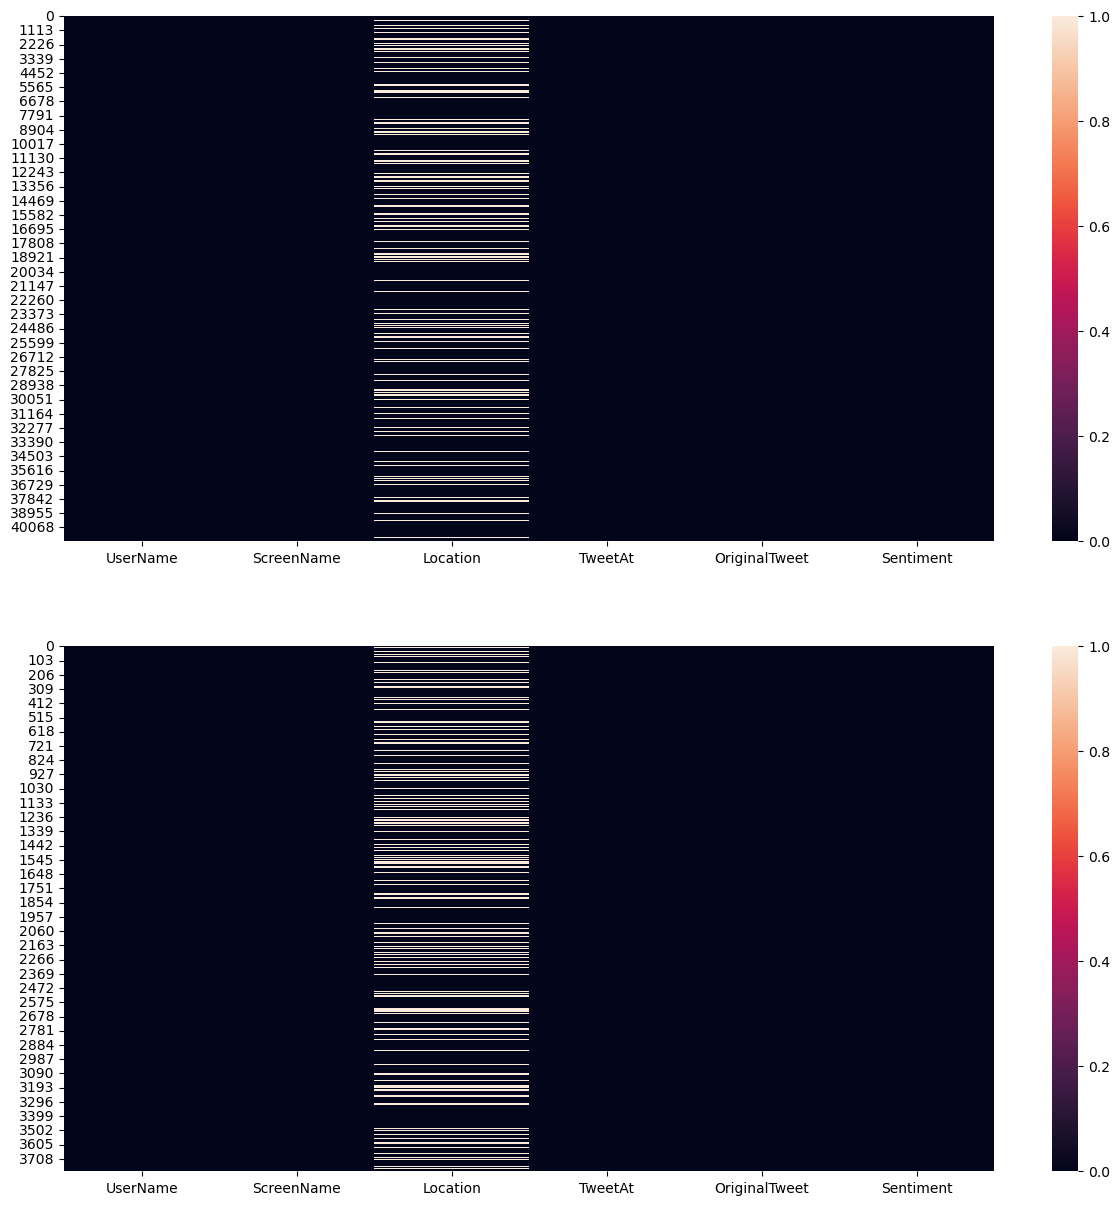

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(15,15))

for i,d in enumerate([df_train.isnull(), df_test.isnull()]):
    sns.heatmap(d, ax=ax[i])

Как видим, пропуски ханимают большая часть столбца Location не заполнена. Удалим всем пропуски, а так же дубликаты в обоих датасетах, также удалим первый столбец в обоих датасетах, обоначающий порядковый номер строки

In [8]:
#удаление дубликатов и пропусков для тренировочного датасета
df_train.drop_duplicates(inplace = True)
df_train.dropna(inplace= True)

#для тестового датасета
df_test.drop_duplicates(inplace = True)
df_test.dropna(inplace = True)

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32567 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       32567 non-null  int64 
 1   ScreenName     32567 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        32567 non-null  object
 4   OriginalTweet  32567 non-null  object
 5   Sentiment      32567 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.7+ MB


Как видим, теперь в датасете отсутствуют пропуски. Проведем анализ очищенных от пропусков данных. 

# Анализ данных

Для начала проанализируем целевую переменную(столбец Sentiment)

In [10]:
print(df_train.Sentiment.value_counts())

Positive              9110
Negative              7763
Neutral               6172
Extremely Positive    5273
Extremely Negative    4249
Name: Sentiment, dtype: int64


In [11]:
def pie(percent_class, labels, radius = 1.0):
    colors = ['#17C37B','#F92969','#FACA0C']
   
    my_pie,_,_ = plt.pie(percent_class, radius = radius, labels=labels,colors=colors,autopct="%.1f%%")
    plt.setp(my_pie, width=0.6, edgecolor='white') 
    plt.show()

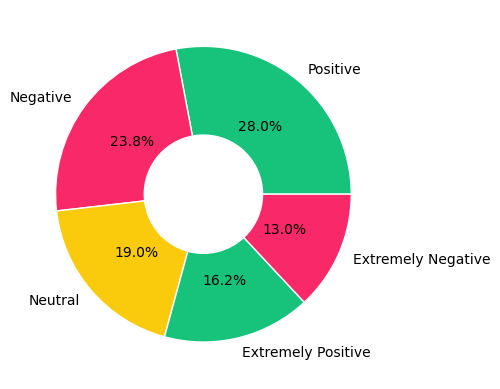

In [12]:
target_class = df_train['Sentiment'].value_counts(normalize= True)
percent_class = target_class.values
labels = target_class.index

pie(percent_class, labels)

Как видим проценты каждого из классов целевой переменной примерно равны. Для упрощения предсказания будем считать твиты, объеденим классы Extremely Negative и Negative, а так же Extremely Positive и Positive

C:\Users\User\AppData\Local\Temp\ipykernel_8568\3813941847.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_train['Sentiment'].loc[df_clean_train['Sentiment'] == 'Extremely Negative'] = 'Negative'
C:\Users\User\AppData\Local\Temp\ipykernel_8568\3813941847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_train['Sentiment'].loc[df_clean_train['Sentiment'] == 'Extremely Positive'] = 'Positive'


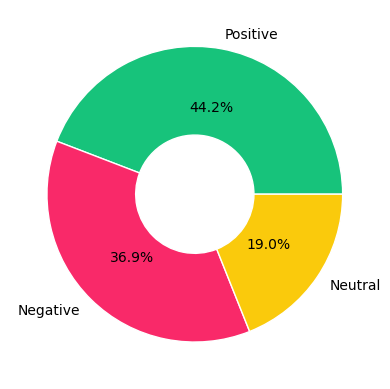

In [13]:
df_clean_train = df_train.copy(deep = True)

df_clean_train['Sentiment'].loc[df_clean_train['Sentiment'] == 'Extremely Negative'] = 'Negative'
df_clean_train['Sentiment'].loc[df_clean_train['Sentiment'] == 'Extremely Positive'] = 'Positive'

target_class = df_clean_train['Sentiment'].value_counts(normalize= True)
percent_class = target_class.values
labels = target_class.index

pie(target_class, labels)

Как видим, в тренировочном датасете преобладают позитивные твиты, однако по-настоящему больших перевесов ни один из классов не имеет. Проанализируем аналогично тестовую выборку.

C:\Users\User\AppData\Local\Temp\ipykernel_8568\1754952420.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_test['Sentiment'].loc[df_test['Sentiment'] == 'Extremely Negative'] = 'Negative'
C:\Users\User\AppData\Local\Temp\ipykernel_8568\1754952420.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_test['Sentiment'].loc[df_test['Sentiment'] == 'Extremely Positive'] = 'Positive'


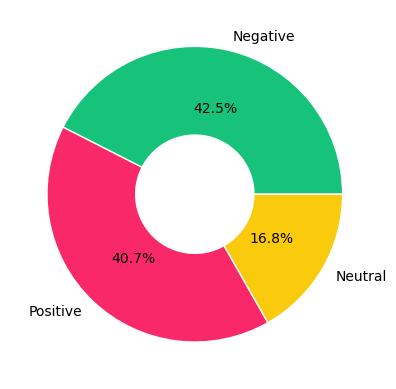

In [14]:
df_clean_test = df_test.copy(deep = True)

df_clean_test['Sentiment'].loc[df_test['Sentiment'] == 'Extremely Negative'] = 'Negative'
df_clean_test['Sentiment'].loc[df_test['Sentiment'] == 'Extremely Positive'] = 'Positive'

target_class = df_clean_test['Sentiment'].value_counts(normalize= True)
percent_class = target_class.values
labels = target_class.index

pie(target_class, labels)

В тестовом же датасете больше преобладают негативные отзывы, однако, так же как и  трениовочной выборке большого перевеса ни в одном из классов нет. Считаем наши классы в тренировочной и тестовой выборках сбалансированными. 

# Очистка данных

Зададим функцию, которая будет очищать текст твита от "мусорных" символов и стопслов

In [15]:
def clean_data(tweet):
    #приводим к нижнему регистру
    tweet = tweet.lower() 
    #убираем значение <unk>, которое встречается в некоторых строках
    tweet = tweet.replace("<unk>", "")
    #убираем ссылки, знаки препинания и прочие символы
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet) 
    tweet = ''.join (c for c in tweet if c not in string.digits)  #убираем все символы, которые относятся к цифрам
    #убираем эмодзи, знаки пунктуации
    tweet = ' '.join(c for c in tweet.split() if emoji.is_emoji(c)==False  
                                    and c not in string.punctuation)
    tweet = tweet.replace("#", "").replace("_", " ").replace("pm","") 
    return tweet

Очистим тренировочный и тестовый датасет

In [16]:
df_clean_train['CleanedTweet'] = df_clean_train['OriginalTweet'].apply(lambda x:clean_data(x))

df_clean_test['CleanedTweet'] = df_clean_test['OriginalTweet'].apply(lambda x:clean_data(x))

Посмотрим на количество слов, оставшееся в твитах тренировочного датасета после очистки данных

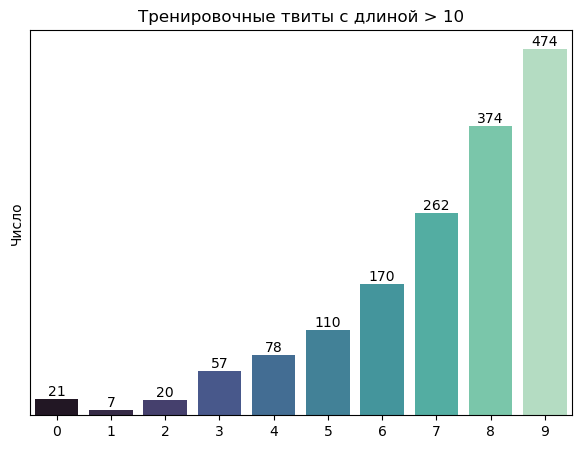

In [17]:
train_text_len = []
for text in df_clean_train['CleanedTweet']:
    tweet_len = len(text.split())
    train_text_len.append(tweet_len)
    
df_clean_train['text_len'] = train_text_len

plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_clean_train[df_clean_train['text_len']<10], palette='mako')
plt.title('Тренировочные твиты с длиной > 10')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Число')
plt.xlabel('')
plt.show()

Аналогично посмотрим для тестового датасета

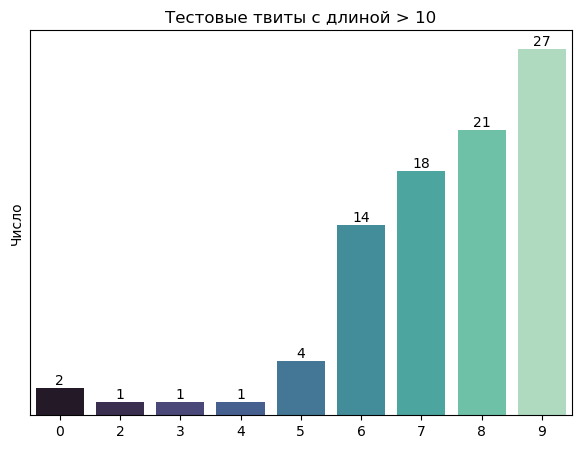

In [18]:
test_text_len = []
for text in df_clean_test['CleanedTweet']:
    tweet_len = len(text.split())
    test_text_len.append(tweet_len)
    
df_clean_test['text_len'] = test_text_len

plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_clean_test[df_clean_test['text_len']<10], palette='mako')
plt.title('Тестовые твиты с длиной > 10')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Число')
plt.xlabel('')
plt.show()

Как видно из графиков, в обоих датасетах присутствуют твиты, в которых после очистки данных или совсем не осталось слов(21 в тренировочном наборе и 2 в тестовом), или осталось менее трех слов(27 в в тренировочном наборе и 1 в тестовом). Для обучения будем использовать только те, в которых есть хотя бы 4 слова.

In [19]:
#для тренировочной выборки
df_clean_train = df_clean_train[df_clean_train['text_len'] > 3]

#для тестовой выборки
df_clean_test = df_clean_test[df_clean_test['text_len'] > 3]

In [20]:
df_clean_train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,CleanedTweet,text_len
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk to your neighbours family to excha...,38
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths to give elder...,13
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive,as news of the regionâs first confirmed covid ...,34
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive,cashier at grocery store was sharing his insig...,27
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toile...,Neutral,was at the supermarket today didnt buy toilet ...,12
...,...,...,...,...,...,...,...,...
41147,44946,89898,"Brooklyn, NY",14-04-2020,YÂall really shitting that much more at home?...,Negative,yâall really shitting that much more at home c...,11
41149,44948,89900,"Toronto, Ontario",14-04-2020,Still shocked by the number of #Toronto superm...,Negative,still shocked by the number of toronto superma...,27
41150,44949,89901,OHIO,14-04-2020,I never that weÂd be in a situation &amp; wor...,Positive,i never that weâd be in a situation amp world ...,33
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral,airline pilots offering to stock supermarket s...,11


Теперь, когда данные датасета очищены от "мусорных" символов и мы точно уверены, что в каждом ячейке текста есть хотя бы 4 слова, токенирузуем текст

In [21]:
#объявим токенизатор
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [22]:
for txt in df_clean_train['CleanedTweet'].values:
    tokens = tokenizer.encode(txt, max_length=TEXT_MAX_LEN, truncation=True)
    
for txt in df_clean_test['CleanedTweet'].values:
    tokens = tokenizer.encode(txt, max_length=TEXT_MAX_LEN, truncation=True)

Закодируем нашу целевую переменную

In [23]:
#закодируем нашу целевую перемнную для тренировочной выборки
df_clean_train['Sentiment'] = df_clean_train['Sentiment'].map({'Negative':0,'Neutral':1,'Positive':2})

#для тестовой выборки
df_clean_test['Sentiment'] = df_clean_test['Sentiment'].map({'Negative':0,'Neutral':1,'Positive':2})

Выделим данные, на которых будем обучать непосредственно саму модель, но перед этим перемешаем внутри датасета все данные

In [24]:
df_clean_train = df_clean_train.sample(frac=1).reset_index(drop=True)
X = df_clean_train['CleanedTweet'].values
y = df_clean_train['Sentiment'].values


df_clean_test = df_clean_test.sample(frac=1).reset_index(drop=True)
X_test = df_clean_test['CleanedTweet'].values
y_test = df_clean_test['Sentiment'].values

Разбиваем на тренировочную и валидационную выборки

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.1, stratify = y, random_state = RANDOM_STATE)

In [26]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [27]:
def tokenize(data,max_len=128) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [28]:
train_input_ids, train_attention_masks = tokenize(X_train)
val_input_ids, val_attention_masks = tokenize(X_valid)
test_input_ids, test_attention_masks = tokenize(X_test)

Теперь зададим саму бертовскую модель

In [29]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [30]:
def create_model(bert_model, max_len=128):
    
    ##params###
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model

In [31]:
model = create_model(bert_model, 128)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [32]:
with tf.device('/GPU:0'): 
    history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=5, batch_size=128)

Epoch 1/5


ResourceExhaustedError: Graph execution error:

Detected at node 'model/tf_bert_model/bert/encoder/layer_._2/attention/self/Softmax' defined at (most recent call last):
    File "D:\Olya_work\anaconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "D:\Olya_work\anaconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "D:\Olya_work\anaconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "D:\Olya_work\anaconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "D:\Olya_work\anaconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\User\AppData\Local\Temp\ipykernel_8568\3984052563.py", line 2, in <module>
      history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=5, batch_size=128)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\transformers\modeling_tf_utils.py", line 1090, in run_call_with_unpacked_inputs
      # (and avoid unnecessary warnings).
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 1118, in call
      outputs = self.bert(
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\transformers\modeling_tf_utils.py", line 1090, in run_call_with_unpacked_inputs
      # (and avoid unnecessary warnings).
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 873, in call
      encoder_outputs = self.encoder(
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 558, in call
      for i, layer_module in enumerate(self.layer):
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 564, in call
      layer_outputs = layer_module(
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 474, in call
      self_attention_outputs = self.attention(
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 390, in call
      self_outputs = self.self_attention(
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 329, in call
      attention_probs = stable_softmax(logits=attention_scores, axis=-1)
    File "D:\Olya_work\anaconda3\envs\tf\lib\site-packages\transformers\tf_utils.py", line 70, in stable_softmax
      return tf.nn.softmax(logits=logits + 1e-9, axis=axis, name=name)
Node: 'model/tf_bert_model/bert/encoder/layer_._2/attention/self/Softmax'
OOM when allocating tensor with shape[128,12,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/tf_bert_model/bert/encoder/layer_._2/attention/self/Softmax}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_27809]